# Conformal Toy Regression


In [25]:
import torch
import torch.nn as nn
import numpy as np
from plotting import make_error_fig
from activation import switchable_activation
from dataset import generate_data
from tqdm.notebook import tqdm


# torch.set_default_dtype(torch.float64)
N_BOUND = -30 if torch.get_default_dtype() == torch.float64 else -20
DTYPE = torch.get_default_dtype()

In [26]:
def conformal_prediction(model, x_cal, y_cal, x_pred, alpha=0.05):
    # via https://www.stat.berkeley.edu/~ryantibs/statlearn-s23/lectures/conformal.pdf
    with torch.inference_mode():
        pred = model(x_cal)
        residual = torch.abs(pred - y_cal).squeeze()
        n_cal = len(residual)
        q_level = np.ceil((1 - alpha) * (1 + n_cal)) / n_cal
        q_hat = torch.quantile(residual, q_level)

        y_hat = model(x_pred)
        return (y_hat - q_hat).flatten(), (y_hat + q_hat).flatten()

In [27]:
class Net(nn.Module):
    def __init__(
        self,
        hdn_dim: int = 14,
        n_layers: int = 2,
        hetero: bool = False,
        activation: str = "relu",
    ) -> None:
        super().__init__()
        self.activation = switchable_activation(activation)
        assert n_layers > 1
        self.layers = []
        self.layers.append(nn.Linear(1, hdn_dim))
        for i in range(n_layers - 1):
            self.layers.append(self.activation)
            if i == n_layers - 2:
                self.layers.append(nn.Linear(hdn_dim, 2 if hetero else 1))
            else:
                self.layers.append(nn.Linear(hdn_dim, hdn_dim))

        self.net = nn.Sequential(*self.layers)

        self._hetero = hetero

    def loss(self, pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        if self._hetero:
            mean = pred[:, 0]
            lvar = pred[:, 1].clamp(N_BOUND, 11)
            nll = 0.5 * ((target - mean) ** 2 / lvar.exp() + lvar)
        else:
            nll = torch.mean((target - pred).pow(2))  # unnormalized
        return torch.mean(nll)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

In [28]:
# define training setup
epochs = 2000
batch_size = 200
n_samples = (
    batch_size * 9
)  # 10 for the other examples, as they don't need to consider a conformal set
unc = 0.1
seed = 42

# get reproducible datapoints
x_train, y_train = generate_data(n_samples, unc=unc, seed=seed)
x_cal, y_cal = generate_data(batch_size, unc=unc, seed=seed + 23)
x_cal = torch.tensor(x_cal[:, None], dtype=DTYPE)
y_cal = torch.tensor(y_cal[:, None], dtype=DTYPE)

# Fit scaler and save the mean and std to undo
# scaling later
Y_STD = y_train.std()
Y_MEAN = y_train.mean()
y_train_scaled = (y_train - Y_MEAN) / Y_STD

y_cal = (y_cal - Y_MEAN) / Y_STD

# Define the model and look at it
trn_len = x_train.shape[0]
hdn_dim = 32
layers = 5  # number of all layers (hidden + 2)
toy_model = Net(hdn_dim=hdn_dim, n_layers=layers, activation="tanh")


# Build dataset
dataset = torch.utils.data.TensorDataset(
    torch.tensor(x_train[:, None], dtype=DTYPE),
    torch.tensor(y_train_scaled, dtype=DTYPE),
)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

opt = torch.optim.AdamW(toy_model.parameters(), lr=5e-3)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, epochs * len(loader))

In [29]:
# Train the model
toy_model.train()

for i in tqdm(range(epochs)):
    train_losses = np.array([])
    for xb, yb in loader:

        # pass data through network
        pred = toy_model(xb)

        # compute loss
        loss = toy_model.loss(pred, yb.unsqueeze(-1))

        train_losses = np.append(train_losses, loss.item())

        # reset gradients in optimizer
        opt.zero_grad()

        # compute gradients
        loss.backward()

        # update weights with optimizer
        opt.step()
        sched.step()

    train_losses_epoch = train_losses.mean()

    if i % 50 == 0:
        tqdm.write(f"epoch={i}, loss={train_losses_epoch:.4f}")

  0%|          | 0/2000 [00:00<?, ?it/s]

epoch=0, loss=0.6902
epoch=50, loss=0.5077
epoch=100, loss=0.5029
epoch=150, loss=0.4542
epoch=200, loss=0.3110
epoch=250, loss=0.0587
epoch=300, loss=0.0453
epoch=350, loss=0.0453
epoch=400, loss=0.0426
epoch=450, loss=0.0436
epoch=500, loss=0.0433
epoch=550, loss=0.0418
epoch=600, loss=0.0426
epoch=650, loss=0.0441
epoch=700, loss=0.0426
epoch=750, loss=0.0439
epoch=800, loss=0.0414
epoch=850, loss=0.0438
epoch=900, loss=0.0408
epoch=950, loss=0.0411
epoch=1000, loss=0.0408
epoch=1050, loss=0.0419
epoch=1100, loss=0.0415
epoch=1150, loss=0.0422
epoch=1200, loss=0.0400
epoch=1250, loss=0.0418
epoch=1300, loss=0.0397
epoch=1350, loss=0.0408
epoch=1400, loss=0.0400
epoch=1450, loss=0.0402
epoch=1500, loss=0.0394
epoch=1550, loss=0.0400
epoch=1600, loss=0.0391
epoch=1650, loss=0.0391
epoch=1700, loss=0.0386
epoch=1750, loss=0.0387
epoch=1800, loss=0.0384
epoch=1850, loss=0.0383
epoch=1900, loss=0.0382
epoch=1950, loss=0.0382


In [30]:
xx = torch.linspace(-1.2, 1.2, 5000).unsqueeze(-1)
toy_model.eval()

rescale = lambda x, mean, std: x * std + mean

with torch.inference_mode():
    pred = rescale(toy_model(xx), Y_MEAN, Y_STD)

In [31]:
# Get conformal prediction intervals
lower_ci, upper_ci = conformal_prediction(toy_model, x_cal, y_cal, xx, alpha=0.05)
lower_ci = rescale(lower_ci, Y_MEAN, Y_STD)
upper_ci = rescale(upper_ci, Y_MEAN, Y_STD)

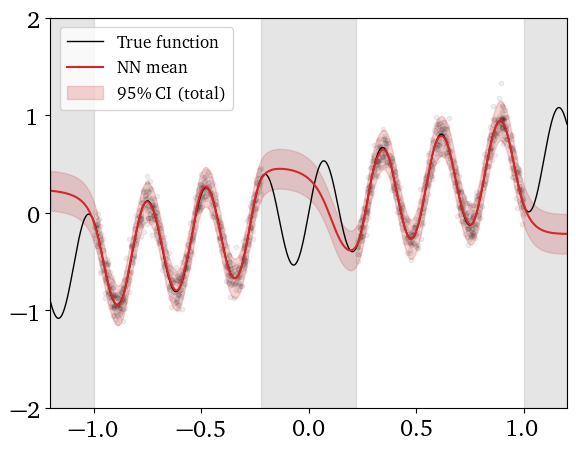

In [32]:
make_error_fig(
    data_train=(x_train, y_train),
    x_values=xx.flatten(),
    y_mean=pred.flatten(),
    y_std_epistemic=0 * pred,
    y_std_aleatoric=0 * pred,
    ci_lower_upper=(lower_ci, upper_ci),
    network_name="NN",
    filename="conformal_toy",
)